In [1]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2

mask_path = '/scratch/suayder/shs25/click_mask/035_Jundiai_HSV_Route_04_FROM'
video_dir = '/scratch/suayder/shs25/snippets/035_Jundiai_HSV_Route_04_FROM/images'

frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

mask_names = [
    p for p in os.listdir(mask_path)
    if os.path.splitext(p)[-1] in [".npy"]
]
mask_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

In [2]:
def show_steps(steps):
    """step is a dict {operation_name: array_result}"""
    if len(steps) == 1:
        for title, image in steps.items():
            plt.imshow(image)
            plt.title(title)
        return

    len_images = len(steps)
    rows = int(np.sqrt(len_images))
    cols = int(np.ceil(len_images / rows))
    fig, axes = plt.subplots(rows, cols, figsize=(15,15))
    axes = axes.flatten()
    for idx, (title, image) in enumerate(steps.items()):
            axes[idx].imshow(image)
            axes[idx].set_title(title)
            axes[idx].axis('off')  # Hide axes ticks

    for idx in range(len_images, len(axes)):
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

def overlaped_mask(image, mask, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)  # Random RGB + Alpha
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])  # Fixed color + Alpha

    h, w = mask.shape[-2:]
    
    # Ensure image is float type for blending
    image = image.astype(np.float32) / 255.0 if image.dtype == np.uint8 else image.astype(np.float32)
    
    # Create an RGB mask with alpha channel
    mask_image = mask.reshape(h, w, 1) * color[:3]  # Apply RGB color
    alpha = (mask * color[3]).reshape(h, w, 1)  # Extract alpha values
    
    # Blend the mask with the original image
    overlapped = (1 - alpha) * image + alpha * mask_image
    
    return np.clip(overlapped, 0, 1)  # Ensure valid pixel range


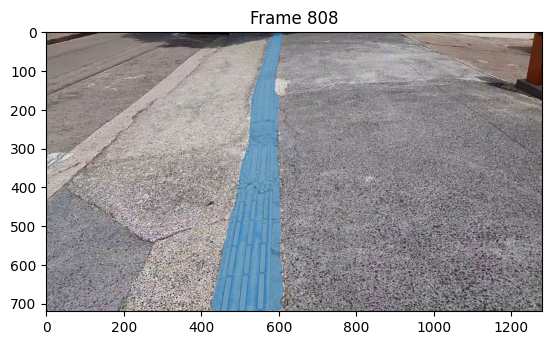

In [3]:
frame_idx = 808
image = np.array(Image.open(os.path.join(video_dir, frame_names[frame_idx])))
mask = np.load(os.path.join(mask_path, mask_names[frame_idx])).squeeze()
show_steps({f'Frame {frame_idx}': overlaped_mask(image, mask)})

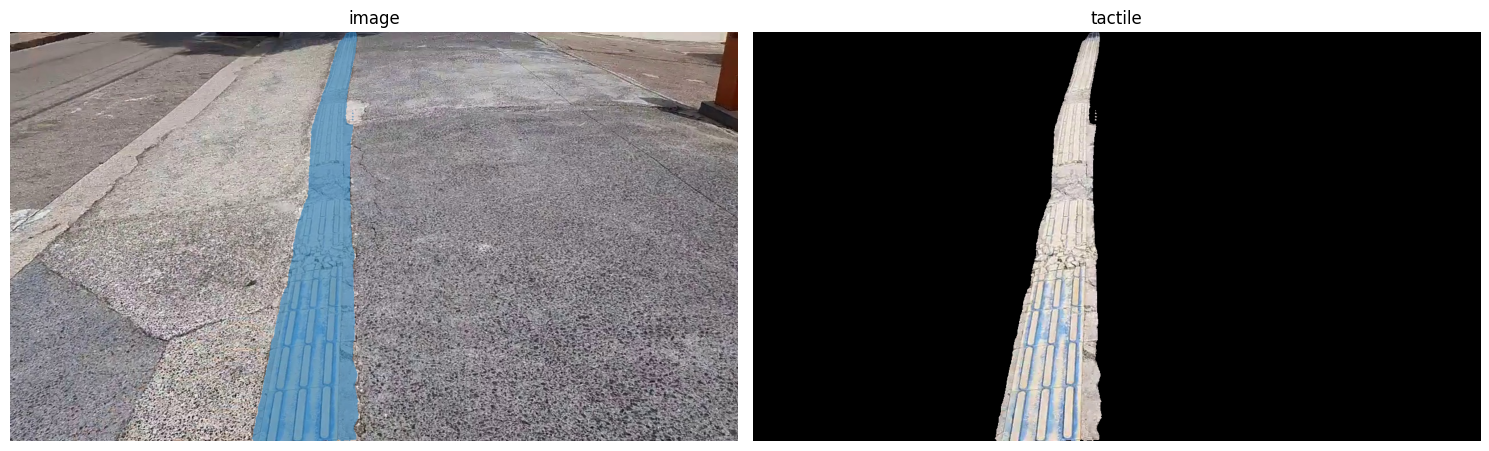

In [4]:
show_steps({f'image': overlaped_mask(image, mask),
           'tactile': image*mask[..., None]})

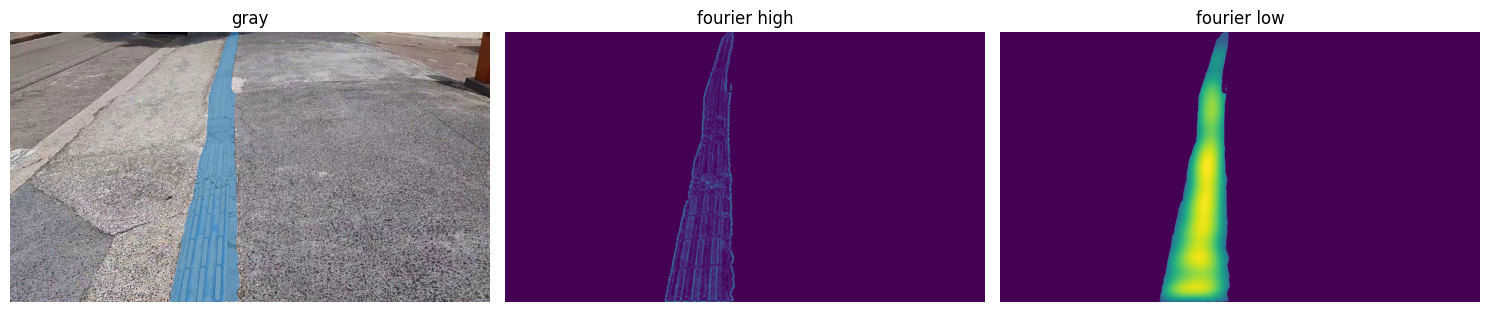

In [5]:
def apply_fourier():
    
    gray = cv2.cvtColor(image*mask[..., None], cv2.COLOR_RGB2GRAY)

    # Apply 2D FFT
    f_transform = np.fft.fft2(gray)
    f_shift = np.fft.fftshift(f_transform)  # Center the low frequencies
    magnitude_spectrum = 20 * np.log(np.abs(f_shift) + 1)  # Log scale for visualization

    return magnitude_spectrum

def low_pass_filter(image, cutoff_freq=30):
    """
    Applies a Low-Pass Filter in the frequency domain to remove high-frequency details.
    - image: Input RGB image (H, W, 3)
    - cutoff_freq: Cutoff frequency for the low-pass filter (larger means more detail is removed)
    """
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Apply 2D FFT
    f_transform = np.fft.fft2(gray)
    f_shift = np.fft.fftshift(f_transform)  # Center the low frequencies

    # Create a Low-Pass Filter (circular mask)
    rows, cols = gray.shape
    crow, ccol = rows // 2, cols // 2  # Center of the image

    # Create a mask with the low-pass filter (1 inside the cutoff, 0 outside)
    mask = np.zeros((rows, cols))
    r, c = np.ogrid[:rows, :cols]
    mask_area = (r - crow) ** 2 + (c - ccol) ** 2 <= cutoff_freq ** 2
    mask[mask_area] = 1

    # Apply the mask to the frequency domain (zero out high frequencies)
    f_shift_filtered = f_shift * mask

    # Inverse FFT to get the filtered image back
    f_ishift = np.fft.ifftshift(f_shift_filtered)
    img_back = np.fft.ifft2(f_ishift)
    img_back = np.abs(img_back)  # Get the magnitude of the inverse FFT

    return img_back

def high_pass_filter(image, cutoff_freq=30):
    """
    Applies a High-Pass Filter in the frequency domain to retain high-frequency details.
    - image: Input RGB image (H, W, 3)
    - cutoff_freq: Cutoff frequency for the high-pass filter (larger means more details retained)
    """
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Apply 2D FFT
    f_transform = np.fft.fft2(gray)
    f_shift = np.fft.fftshift(f_transform)  # Center the low frequencies

    # Create a Low-Pass Filter (circular mask)
    rows, cols = gray.shape
    crow, ccol = rows // 2, cols // 2  # Center of the image

    # Create a mask with the low-pass filter (1 inside the cutoff, 0 outside)
    mask = np.zeros((rows, cols))
    r, c = np.ogrid[:rows, :cols]
    mask_area = (r - crow) ** 2 + (c - ccol) ** 2 <= cutoff_freq ** 2
    mask[mask_area] = 1

    # Apply the mask to the frequency domain (zero out low frequencies for High-Pass Filter)
    f_shift_low_pass = f_shift * mask

    # Subtract the low-pass filtered image from the original Fourier transform
    f_shift_high_pass = f_shift - f_shift_low_pass

    # Inverse FFT to get the high-pass filtered image back
    f_ishift = np.fft.ifftshift(f_shift_high_pass)
    img_back = np.fft.ifft2(f_ishift)
    img_back = np.abs(img_back)  # Get the magnitude of the inverse FFT

    return img_back

    
show_steps({'gray': overlaped_mask(image, mask),
            'fourier high': high_pass_filter(image*mask[..., None], 50)*mask[...],
           'fourier low': low_pass_filter(image*mask[..., None], 10)*mask[...],})

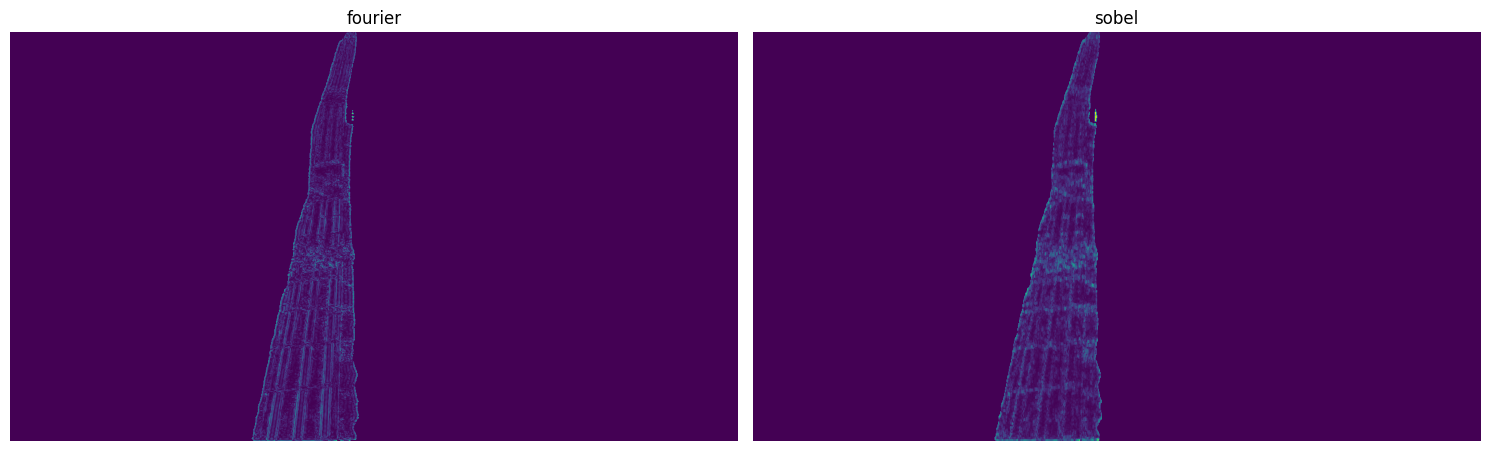

In [34]:
def apply_sobel_horizontal(image):
    if len(image.shape) == 3:  # Convert to grayscale if the image is in color
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    sobel_x = cv2.Sobel(image, cv2.CV_64F, dx=1, dy=0, ksize=3)  # Horizontal edges
    sobel_x = cv2.convertScaleAbs(sobel_x)  # Convert back to uint8

    return sobel_x

def apply_scharr_horizontal(image):

    if len(image.shape) == 3:  # Convert to grayscale if the image is in color
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    scharr_x = cv2.Scharr(image, cv2.CV_64F, dx=1, dy=0)
    scharr_x = cv2.convertScaleAbs(scharr_x)  # Convert back to uint8

    return scharr_x

def apply_prewitt_horizontal(image):

    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Prewitt kernels
    prewitt_x = np.array([[1, 0, -1],
                           [1, 0, -1],
                           [1, 0, -1]], dtype=np.float32)

    horizontal_edges = cv2.filter2D(image, cv2.CV_64F, prewitt_x)
    horizontal_edges = cv2.convertScaleAbs(horizontal_edges)
    return horizontal_edges

def apply_canny(image, low_threshold=50, high_threshold=150):

    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    edges = cv2.Canny(image, low_threshold, high_threshold)
    return edges


def apply_morph_gradient_horizontal(image, kernel_size=5):

    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Horizontal kernel
    kernel = np.ones((kernel_size, 1), np.uint8)

    # Morphological gradient (dilation - erosion)
    morph_gradient = cv2.morphologyEx(image, cv2.MORPH_GRADIENT, kernel)

    return morph_gradient

def apply_top_hat_horizontal(image, kernel_size=15):

    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Horizontal kernel
    kernel = np.ones((kernel_size, 1), np.uint8)

    # Top-hat transformation
    top_hat = cv2.morphologyEx(image, cv2.MORPH_TOPHAT, kernel)

    return top_hat

# fourier = (high_pass_filter(image*mask[..., None], 100)*mask[...]).astype(np.uint8)
show_steps({'fourier': fourier,
           'sobel': apply_morph_gradient_horizontal(fourier)})